# Transform spike rates to behaviour using RNN

## Setup

### Environment Setup

Configure the local or Google Colab environments.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys
try:
    # Only on works on Google Colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    # Configure kaggle if necessary
    if not (Path.home() / '.kaggle').is_dir():
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
    
    !pip install git+https://github.com/SachsLab/indl.git
    
    if Path.cwd().stem == 'MonkeyPFCSaccadeStudies':
        os.chdir(Path.cwd().parent)
    
    if not (Path.cwd() / 'MonkeyPFCSaccadeStudies').is_dir():
        !git clone --single-branch --recursive https://github.com/SachsLab/MonkeyPFCSaccadeStudies.git
        sys.path.append(str(Path.cwd() / 'MonkeyPFCSaccadeStudies'))
    
    os.chdir('MonkeyPFCSaccadeStudies')
        
    !pip install -q kaggle
    
    # Latest version of SKLearn
    !pip install -U scikit-learn
    
    IN_COLAB = True
    
except ModuleNotFoundError:    
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
        
    # Add indl repository to path.
    # Eventually this should already be pip installed, but it's still under heavy development so this is easier for now.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'indl'
    sys.path.append(str(indl_path))
    
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    
    IN_COLAB = False

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
# Additional imports
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from indl.display import turbo_cmap

In [4]:
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

### Download Data (if necessary)

In [5]:
if IN_COLAB:
    data_path = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    data_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


### (Prepare to) Load Data

We will use a custom function `load_macaque_pfc` to load the data into memory.

There are 4 different strings to be passed to the import `x_chunk` argument:
* 'analogsignals' - if present. Returns 1 kHz LFPs
* 'gaze'          - Returns 2-channel gaze data.
* 'spikerates'    - Returns smoothed spikerates
* 'spiketrains'

The `y_type` argument can be
* 'pair and choice' - returns Y as np.array of (target_pair, choice_within_pair)
* 'encoded input' - returns Y as np.array of shape (n_samples, 10) (explained below)
* 'replace with column name' - returns Y as a vector of per-trial values. e.g., 'sacClass'

The actual data we load depends on the particular analysis below.

In [6]:
from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

## Decoding trial class (0:7) from spike rates

### Load Data

Load the per-trial spikerates and saccadeClass (0:7)

In [7]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
Y_class = tf.keras.utils.to_categorical(Y_class, num_classes=8)


Importing session sra3_1_j_050_00+


### Create Model

Our model objective is to transform timeseries segments into probabilities of each class.

Let's start with a function to make the model:

In [8]:
from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer
from tensorflow.keras import layers

@check_inputs
def make_model(
    _input,
    filt=8,
    kernLength=25,
    ds_rate=10,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    _y = _input
    
    input_shape = _input.shape.as_list()
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    _y = layers.Reshape(input_shape[1:])(_y)
    _y = tf.keras.layers.Conv2D(filt, (1, kernLength), padding='valid', data_format=None,
                                dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.DepthwiseConv2D((_y.shape.as_list()[1], 1), padding='valid',
                                      depth_multiplier=1, data_format=None, dilation_rate=(1, 1),
                                      activation=None, use_bias=True, depthwise_initializer='glorot_uniform',
                                      bias_initializer='zeros', depthwise_regularizer=None,
                                      bias_regularizer=None, activity_regularizer=None,
                                      depthwise_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.AveragePooling2D(pool_size=(1, ds_rate))(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = layers.Reshape(_y.shape.as_list()[2:])(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    _y = parts.Classify(_y, n_classes=8, norm_rate=norm_rate)
    

    if return_model is False:
        return _y
    else:
        return tf.keras.models.Model(inputs=_input, outputs=_y)

In [12]:
LABEL_SMOOTHING = 0.2
model_kwargs = dict(
    filt=8,
    kernLength=25,
    ds_rate=9,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=32
)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

input_spec = tf.data.Dataset.from_tensor_slices(X_rates).batch(16, drop_remainder=True).element_spec
model = make_model(
    input_spec,
    **model_kwargs
)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
model.summary()
if False:
    tf.keras.utils.plot_model(
        model,
        to_file='model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96
    )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 171)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 171, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 147, 8)        208       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 147, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 147, 8)         264       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 147, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 1, 147, 8)         0     

### Training Loop

In [10]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 180


def get_hists_acc(sess_id, verbose=1):
    print(f"Processing session {sess_id}...")
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(
            ds_train.element_spec[0],
            **model_kwargs
        )
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'r2c_lstm_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"Session {sess_id} overall accuracy: {accuracy}%")
    
    return history, accuracy
        

Processing session sra3_1_j_050_00+...
	Split 1 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.24138, saving model to r2c_lstm_sra3_1_j_050_00+_split0.h5
16/16 - 2s - loss: 2.2216 - accuracy: 0.1406 - val_loss: 2.1215 - val_accuracy: 0.2414
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.24138
16/16 - 0s - loss: 2.0723 - accuracy: 0.2031 - val_loss: 2.1142 - val_accuracy: 0.2414
Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.24138
16/16 - 0s - loss: 2.0055 - accuracy: 0.3203 - val_loss: 2.1037 - val_accuracy: 0.2414
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.24138 to 0.31034, saving model to r2c_lstm_sra3_1_j_050_00+_split0.h5
16/16 - 0s - loss: 1.9388 - accuracy: 0.3008 - val_loss: 2.0875 - val_accuracy: 0.3103
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.31034 to 0.48276, saving model to r2c_lstm_sra3_1_j_050_00+_split0.h5
16/16 - 0s - loss: 1.8501 - accuracy: 0.4141 - va

Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2268 - accuracy: 0.8164 - val_loss: 1.1294 - val_accuracy: 0.8276
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2178 - accuracy: 0.8164 - val_loss: 1.1305 - val_accuracy: 0.8276
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2412 - accuracy: 0.7969 - val_loss: 1.1165 - val_accuracy: 0.7931
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2266 - accuracy: 0.7812 - val_loss: 1.1231 - val_accuracy: 0.7586
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2196 - accuracy: 0.8164 - val_loss: 1.1069 - val_accuracy: 0.8276
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2372 - accuracy: 0.7891 - val_loss: 1.1237 - val_accuracy: 0.8276
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.8

Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1395 - accuracy: 0.8359 - val_loss: 1.0588 - val_accuracy: 0.8276
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1242 - accuracy: 0.8203 - val_loss: 1.0987 - val_accuracy: 0.7586
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1207 - accuracy: 0.8359 - val_loss: 1.0787 - val_accuracy: 0.7586
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1019 - accuracy: 0.8750 - val_loss: 1.0690 - val_accuracy: 0.7931
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1456 - accuracy: 0.8281 - val_loss: 1.0514 - val_accuracy: 0.8276
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1100 - accuracy: 0.8320 - val_loss: 1.0522 - val_accuracy: 0.7931
Epoch 108/180

Epoch 00108: val_accuracy did not improve f

Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.0534 - accuracy: 0.9102 - val_loss: 1.0634 - val_accuracy: 0.8276
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.0948 - accuracy: 0.8750 - val_loss: 1.0672 - val_accuracy: 0.8276
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.0717 - accuracy: 0.8906 - val_loss: 1.0588 - val_accuracy: 0.7931
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.0913 - accuracy: 0.8594 - val_loss: 1.0586 - val_accuracy: 0.8276
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1065 - accuracy: 0.8555 - val_loss: 1.0558 - val_accuracy: 0.8276
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.0593 - accuracy: 0.9141 - val_loss: 1.0615 - val_accuracy: 0.8276
Epoch 160/180

Epoch 00160: val_accuracy did not improve f

Epoch 24/180

Epoch 00024: val_accuracy improved from 0.68966 to 0.72414, saving model to r2c_lstm_sra3_1_j_050_00+_split1.h5
16/16 - 0s - loss: 1.3497 - accuracy: 0.7461 - val_loss: 1.3473 - val_accuracy: 0.7241
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3927 - accuracy: 0.6797 - val_loss: 1.3353 - val_accuracy: 0.6897
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3279 - accuracy: 0.7852 - val_loss: 1.3154 - val_accuracy: 0.6897
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3220 - accuracy: 0.7617 - val_loss: 1.3048 - val_accuracy: 0.6897
Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3134 - accuracy: 0.7773 - val_loss: 1.2905 - val_accuracy: 0.6552
Epoch 29/180

Epoch 00029: val_accuracy improved from 0.72414 to 0.75862, saving model to r2c_lstm_sra3_1_j_050_00+_split1.h5
16/16 - 0s - loss: 1.3405 - accuracy:

Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1949 - accuracy: 0.8281 - val_loss: 1.1046 - val_accuracy: 0.7586
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1719 - accuracy: 0.8438 - val_loss: 1.0881 - val_accuracy: 0.7931
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1380 - accuracy: 0.8555 - val_loss: 1.0961 - val_accuracy: 0.7931
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1600 - accuracy: 0.8359 - val_loss: 1.0922 - val_accuracy: 0.7931
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1299 - accuracy: 0.8555 - val_loss: 1.0844 - val_accuracy: 0.8276
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1142 - accuracy: 0.8750 - val_loss: 1.0636 - val_accuracy: 0.8621
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.8

Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.0838 - accuracy: 0.8945 - val_loss: 1.1021 - val_accuracy: 0.8276
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1125 - accuracy: 0.8672 - val_loss: 1.0661 - val_accuracy: 0.8621
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.0961 - accuracy: 0.8906 - val_loss: 1.0672 - val_accuracy: 0.8621
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1014 - accuracy: 0.8906 - val_loss: 1.0706 - val_accuracy: 0.8276
Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.1049 - accuracy: 0.8867 - val_loss: 1.0608 - val_accuracy: 0.8276
Epoch 133/180

Epoch 00133: val_accuracy did not improve from 0.89655
16/16 - 0s - loss: 1.0718 - accuracy: 0.8945 - val_loss: 1.1083 - val_accuracy: 0.8276
Epoch 134/180

Epoch 00134: val_accuracy did not improve f

	Split 3 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.13793, saving model to r2c_lstm_sra3_1_j_050_00+_split2.h5
16/16 - 2s - loss: 2.2016 - accuracy: 0.1133 - val_loss: 2.1208 - val_accuracy: 0.1379
Epoch 2/180

Epoch 00002: val_accuracy improved from 0.13793 to 0.27586, saving model to r2c_lstm_sra3_1_j_050_00+_split2.h5
16/16 - 0s - loss: 2.0805 - accuracy: 0.2227 - val_loss: 2.1120 - val_accuracy: 0.2759
Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.27586
16/16 - 0s - loss: 1.9913 - accuracy: 0.3633 - val_loss: 2.0996 - val_accuracy: 0.2759
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.27586 to 0.31034, saving model to r2c_lstm_sra3_1_j_050_00+_split2.h5
16/16 - 0s - loss: 1.9113 - accuracy: 0.4570 - val_loss: 2.0812 - val_accuracy: 0.3103
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.31034 to 0.34483, saving model to r2c_lstm_sra3_1_j_050_00+_split2.h5
16/16 - 0s - loss: 1.8164 - acc

Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2045 - accuracy: 0.8164 - val_loss: 1.1463 - val_accuracy: 0.7931
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2229 - accuracy: 0.8125 - val_loss: 1.1629 - val_accuracy: 0.7931
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2384 - accuracy: 0.8125 - val_loss: 1.1526 - val_accuracy: 0.7586
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2352 - accuracy: 0.7812 - val_loss: 1.1366 - val_accuracy: 0.7931
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2344 - accuracy: 0.7812 - val_loss: 1.1340 - val_accuracy: 0.7931
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.2231 - accuracy: 0.7969 - val_loss: 1.1319 - val_accuracy: 0.8276
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.8

Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0933 - accuracy: 0.8945 - val_loss: 1.2814 - val_accuracy: 0.6552
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1054 - accuracy: 0.8633 - val_loss: 1.3013 - val_accuracy: 0.6552
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0930 - accuracy: 0.8984 - val_loss: 1.2939 - val_accuracy: 0.6552
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1447 - accuracy: 0.8750 - val_loss: 1.3527 - val_accuracy: 0.6552
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1258 - accuracy: 0.8789 - val_loss: 1.3429 - val_accuracy: 0.6552
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0614 - accuracy: 0.8945 - val_loss: 1.2928 - val_accuracy: 0.6552
Epoch 108/180

Epoch 00108: val_accuracy did not improve f

Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0649 - accuracy: 0.9258 - val_loss: 1.3617 - val_accuracy: 0.6552
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0750 - accuracy: 0.9062 - val_loss: 1.3432 - val_accuracy: 0.6897
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0521 - accuracy: 0.9297 - val_loss: 1.3566 - val_accuracy: 0.6552
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0461 - accuracy: 0.9141 - val_loss: 1.3514 - val_accuracy: 0.6552
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0462 - accuracy: 0.9297 - val_loss: 1.3888 - val_accuracy: 0.6552
Epoch 160/180

Epoch 00160: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0727 - accuracy: 0.8906 - val_loss: 1.4772 - val_accuracy: 0.6552
Epoch 161/180

Epoch 00161: val_accuracy did not improve f

Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3399 - accuracy: 0.7617 - val_loss: 1.3478 - val_accuracy: 0.7241
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3679 - accuracy: 0.7227 - val_loss: 1.3345 - val_accuracy: 0.6897
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.72414
16/16 - 0s - loss: 1.3356 - accuracy: 0.7500 - val_loss: 1.3296 - val_accuracy: 0.6552
Epoch 27/180

Epoch 00027: val_accuracy improved from 0.72414 to 0.75862, saving model to r2c_lstm_sra3_1_j_050_00+_split3.h5
16/16 - 0s - loss: 1.3269 - accuracy: 0.7383 - val_loss: 1.3059 - val_accuracy: 0.7586
Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.75862
16/16 - 0s - loss: 1.3253 - accuracy: 0.7305 - val_loss: 1.3039 - val_accuracy: 0.7241
Epoch 29/180

Epoch 00029: val_accuracy improved from 0.75862 to 0.79310, saving model to r2c_lstm_sra3_1_j_050_00+_split3.h5
16/16 - 0s - loss: 1.3260 - accuracy:

Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1711 - accuracy: 0.8320 - val_loss: 1.1728 - val_accuracy: 0.7931
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1476 - accuracy: 0.8242 - val_loss: 1.1557 - val_accuracy: 0.7931
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1250 - accuracy: 0.8750 - val_loss: 1.1572 - val_accuracy: 0.7931
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1826 - accuracy: 0.8242 - val_loss: 1.1646 - val_accuracy: 0.7586
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1468 - accuracy: 0.8438 - val_loss: 1.1640 - val_accuracy: 0.7586
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.79310
16/16 - 0s - loss: 1.1169 - accuracy: 0.8477 - val_loss: 1.1651 - val_accuracy: 0.7931
Epoch 82/180

Epoch 00082: val_accuracy did not improve from 0.7

Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.0840 - accuracy: 0.9023 - val_loss: 1.2143 - val_accuracy: 0.7586
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.0781 - accuracy: 0.9023 - val_loss: 1.2207 - val_accuracy: 0.7931
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.0529 - accuracy: 0.9102 - val_loss: 1.2357 - val_accuracy: 0.7586
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.0902 - accuracy: 0.8906 - val_loss: 1.2428 - val_accuracy: 0.7241
Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1021 - accuracy: 0.8789 - val_loss: 1.2378 - val_accuracy: 0.7586
Epoch 133/180

Epoch 00133: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.0810 - accuracy: 0.8828 - val_loss: 1.2214 - val_accuracy: 0.7586
Epoch 134/180

Epoch 00134: val_accuracy did not improve f

	Split 5 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.24138, saving model to r2c_lstm_sra3_1_j_050_00+_split4.h5
16/16 - 2s - loss: 2.1609 - accuracy: 0.1602 - val_loss: 2.1212 - val_accuracy: 0.2414
Epoch 2/180

Epoch 00002: val_accuracy did not improve from 0.24138
16/16 - 0s - loss: 2.0782 - accuracy: 0.2227 - val_loss: 2.1135 - val_accuracy: 0.2414
Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.24138
16/16 - 0s - loss: 2.0176 - accuracy: 0.2969 - val_loss: 2.1032 - val_accuracy: 0.2414
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.24138 to 0.34483, saving model to r2c_lstm_sra3_1_j_050_00+_split4.h5
16/16 - 0s - loss: 1.9337 - accuracy: 0.3945 - val_loss: 2.0878 - val_accuracy: 0.3448
Epoch 5/180

Epoch 00005: val_accuracy improved from 0.34483 to 0.37931, saving model to r2c_lstm_sra3_1_j_050_00+_split4.h5
16/16 - 0s - loss: 1.8323 - accuracy: 0.4258 - val_loss: 2.0642 - val_accuracy: 0.3793
E

Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.2047 - accuracy: 0.8438 - val_loss: 1.1458 - val_accuracy: 0.7931
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.2037 - accuracy: 0.8008 - val_loss: 1.1467 - val_accuracy: 0.7931
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.2064 - accuracy: 0.8125 - val_loss: 1.1605 - val_accuracy: 0.7931
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1986 - accuracy: 0.8242 - val_loss: 1.1752 - val_accuracy: 0.7931
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.2233 - accuracy: 0.8047 - val_loss: 1.1519 - val_accuracy: 0.7931
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1963 - accuracy: 0.8086 - val_loss: 1.1604 - val_accuracy: 0.7931
Epoch 55/180

Epoch 00055: val_accuracy did not improve from 0.8

Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1030 - accuracy: 0.9023 - val_loss: 1.1635 - val_accuracy: 0.8276
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1227 - accuracy: 0.8594 - val_loss: 1.1449 - val_accuracy: 0.8276
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.0882 - accuracy: 0.8867 - val_loss: 1.1381 - val_accuracy: 0.7931
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1052 - accuracy: 0.8672 - val_loss: 1.1452 - val_accuracy: 0.8276
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.1126 - accuracy: 0.8672 - val_loss: 1.1434 - val_accuracy: 0.8276
Epoch 107/180

Epoch 00107: val_accuracy did not improve from 0.82759
16/16 - 0s - loss: 1.0888 - accuracy: 0.8750 - val_loss: 1.1376 - val_accuracy: 0.7931
Epoch 108/180

Epoch 00108: val_accuracy did not improve f

Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0848 - accuracy: 0.8672 - val_loss: 1.1896 - val_accuracy: 0.7931
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0501 - accuracy: 0.9297 - val_loss: 1.2083 - val_accuracy: 0.7586
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1002 - accuracy: 0.8906 - val_loss: 1.1949 - val_accuracy: 0.7931
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.1117 - accuracy: 0.8867 - val_loss: 1.1812 - val_accuracy: 0.7586
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0543 - accuracy: 0.9180 - val_loss: 1.1642 - val_accuracy: 0.7931
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.86207
16/16 - 0s - loss: 1.0735 - accuracy: 0.8984 - val_loss: 1.1813 - val_accuracy: 0.7931
Epoch 160/180

Epoch 00160: val_accuracy did not improve f

Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.3765 - accuracy: 0.7656 - val_loss: 1.4053 - val_accuracy: 0.7857
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.3303 - accuracy: 0.7734 - val_loss: 1.3773 - val_accuracy: 0.7857
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.3374 - accuracy: 0.7539 - val_loss: 1.3509 - val_accuracy: 0.7857
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.3328 - accuracy: 0.7539 - val_loss: 1.3294 - val_accuracy: 0.7857
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.3222 - accuracy: 0.7891 - val_loss: 1.3060 - val_accuracy: 0.7857
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.3004 - accuracy: 0.7891 - val_loss: 1.3004 - val_accuracy: 0.7857
Epoch 28/180

Epoch 00028: val_accuracy did not improve from 0.7

Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1551 - accuracy: 0.8633 - val_loss: 1.1383 - val_accuracy: 0.8214
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1719 - accuracy: 0.8594 - val_loss: 1.1328 - val_accuracy: 0.7857
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1470 - accuracy: 0.8516 - val_loss: 1.1391 - val_accuracy: 0.7500
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1381 - accuracy: 0.8672 - val_loss: 1.1240 - val_accuracy: 0.7500
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1391 - accuracy: 0.8477 - val_loss: 1.1464 - val_accuracy: 0.7500
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1364 - accuracy: 0.8867 - val_loss: 1.1294 - val_accuracy: 0.8214
Epoch 81/180

Epoch 00081: val_accuracy did not improve from 0.8

Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0693 - accuracy: 0.9023 - val_loss: 1.0867 - val_accuracy: 0.8214
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0928 - accuracy: 0.8945 - val_loss: 1.0692 - val_accuracy: 0.8214
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0940 - accuracy: 0.8945 - val_loss: 1.0609 - val_accuracy: 0.7857
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0554 - accuracy: 0.9062 - val_loss: 1.0708 - val_accuracy: 0.8214
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0661 - accuracy: 0.9023 - val_loss: 1.0618 - val_accuracy: 0.8214
Epoch 132/180

Epoch 00132: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0747 - accuracy: 0.9023 - val_loss: 1.0912 - val_accuracy: 0.7857
Epoch 133/180

Epoch 00133: val_accuracy did not improve f

Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0554 - accuracy: 0.9219 - val_loss: 1.0540 - val_accuracy: 0.8929
	Split 7 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.21429, saving model to r2c_lstm_sra3_1_j_050_00+_split6.h5
16/16 - 2s - loss: 2.1733 - accuracy: 0.1211 - val_loss: 2.1196 - val_accuracy: 0.2143
Epoch 2/180

Epoch 00002: val_accuracy improved from 0.21429 to 0.25000, saving model to r2c_lstm_sra3_1_j_050_00+_split6.h5
16/16 - 0s - loss: 2.0795 - accuracy: 0.2266 - val_loss: 2.1108 - val_accuracy: 0.2500
Epoch 3/180

Epoch 00003: val_accuracy did not improve from 0.25000
16/16 - 0s - loss: 1.9869 - accuracy: 0.3789 - val_loss: 2.0978 - val_accuracy: 0.2500
Epoch 4/180

Epoch 00004: val_accuracy improved from 0.25000 to 0.28571, saving model to r2c_lstm_sra3_1_j_050_00+_split6.h5
16/16 - 0s - loss: 1.8904 - accuracy: 0.4492 - val_loss: 2.0795 - val_accuracy: 0.2857

Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.2344 - accuracy: 0.7930 - val_loss: 1.1736 - val_accuracy: 0.7857
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1919 - accuracy: 0.8320 - val_loss: 1.1568 - val_accuracy: 0.7857
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.2453 - accuracy: 0.7656 - val_loss: 1.1559 - val_accuracy: 0.8214
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1977 - accuracy: 0.8477 - val_loss: 1.1496 - val_accuracy: 0.8214
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1855 - accuracy: 0.8398 - val_loss: 1.1447 - val_accuracy: 0.8214
Epoch 53/180

Epoch 00053: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.2357 - accuracy: 0.7734 - val_loss: 1.1504 - val_accuracy: 0.7500
Epoch 54/180

Epoch 00054: val_accuracy did not improve from 0.8

Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1019 - accuracy: 0.8789 - val_loss: 1.1752 - val_accuracy: 0.7143
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1217 - accuracy: 0.8828 - val_loss: 1.1774 - val_accuracy: 0.7143
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0813 - accuracy: 0.9258 - val_loss: 1.2102 - val_accuracy: 0.7143
Epoch 104/180

Epoch 00104: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0998 - accuracy: 0.8906 - val_loss: 1.1891 - val_accuracy: 0.7500
Epoch 105/180

Epoch 00105: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1061 - accuracy: 0.8594 - val_loss: 1.1880 - val_accuracy: 0.7143
Epoch 106/180

Epoch 00106: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1408 - accuracy: 0.8438 - val_loss: 1.1825 - val_accuracy: 0.7143
Epoch 107/180

Epoch 00107: val_accuracy did not improve f

Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0877 - accuracy: 0.8906 - val_loss: 1.2080 - val_accuracy: 0.7500
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0254 - accuracy: 0.9297 - val_loss: 1.2174 - val_accuracy: 0.7143
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0918 - accuracy: 0.8867 - val_loss: 1.1686 - val_accuracy: 0.7500
Epoch 157/180

Epoch 00157: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0370 - accuracy: 0.9375 - val_loss: 1.2087 - val_accuracy: 0.7857
Epoch 158/180

Epoch 00158: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.0305 - accuracy: 0.9336 - val_loss: 1.2016 - val_accuracy: 0.7857
Epoch 159/180

Epoch 00159: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1052 - accuracy: 0.8984 - val_loss: 1.2010 - val_accuracy: 0.7500
Epoch 160/180

Epoch 00160: val_accuracy did not improve f

16/16 - 0s - loss: 1.4284 - accuracy: 0.6719 - val_loss: 1.4090 - val_accuracy: 0.8571
Epoch 22/180

Epoch 00022: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.4094 - accuracy: 0.6992 - val_loss: 1.3845 - val_accuracy: 0.8571
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.3337 - accuracy: 0.7656 - val_loss: 1.3679 - val_accuracy: 0.8571
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.3539 - accuracy: 0.7656 - val_loss: 1.3509 - val_accuracy: 0.8214
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.3402 - accuracy: 0.7656 - val_loss: 1.3174 - val_accuracy: 0.8214
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.3146 - accuracy: 0.8008 - val_loss: 1.2978 - val_accuracy: 0.8214
Epoch 27/180

Epoch 00027: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.3292 - accuracy: 0.7734 - val_loss: 1.2750 

Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1486 - accuracy: 0.8438 - val_loss: 1.1360 - val_accuracy: 0.8214
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1853 - accuracy: 0.8047 - val_loss: 1.1702 - val_accuracy: 0.7857
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1721 - accuracy: 0.8203 - val_loss: 1.1609 - val_accuracy: 0.7500
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1745 - accuracy: 0.7969 - val_loss: 1.1346 - val_accuracy: 0.7500
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1568 - accuracy: 0.8086 - val_loss: 1.1255 - val_accuracy: 0.7500
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1428 - accuracy: 0.8359 - val_loss: 1.1631 - val_accuracy: 0.7143
Epoch 80/180

Epoch 00080: val_accuracy did not improve from 0.8

Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0872 - accuracy: 0.8516 - val_loss: 1.1506 - val_accuracy: 0.8214
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0980 - accuracy: 0.8477 - val_loss: 1.1260 - val_accuracy: 0.8571
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0866 - accuracy: 0.8750 - val_loss: 1.1834 - val_accuracy: 0.7857
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0797 - accuracy: 0.8828 - val_loss: 1.1435 - val_accuracy: 0.8214
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.0559 - accuracy: 0.8750 - val_loss: 1.1407 - val_accuracy: 0.7857
Epoch 131/180

Epoch 00131: val_accuracy did not improve from 0.89286
16/16 - 0s - loss: 1.1189 - accuracy: 0.8594 - val_loss: 1.0995 - val_accuracy: 0.8929
Epoch 132/180

Epoch 00132: val_accuracy did not improve f

Epoch 178/180

Epoch 00178: val_accuracy did not improve from 0.96429
16/16 - 0s - loss: 1.0439 - accuracy: 0.9062 - val_loss: 1.0880 - val_accuracy: 0.9286
Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.96429
16/16 - 0s - loss: 1.0430 - accuracy: 0.9141 - val_loss: 1.1053 - val_accuracy: 0.8929
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.96429
16/16 - 0s - loss: 1.0561 - accuracy: 0.8945 - val_loss: 1.1691 - val_accuracy: 0.7857
	Split 9 of 10
Train for 16 steps, validate for 2 steps
Epoch 1/180

Epoch 00001: val_accuracy improved from -inf to 0.17857, saving model to r2c_lstm_sra3_1_j_050_00+_split8.h5
16/16 - 2s - loss: 2.1708 - accuracy: 0.1445 - val_loss: 2.1210 - val_accuracy: 0.1786
Epoch 2/180

Epoch 00002: val_accuracy improved from 0.17857 to 0.21429, saving model to r2c_lstm_sra3_1_j_050_00+_split8.h5
16/16 - 0s - loss: 2.0857 - accuracy: 0.2148 - val_loss: 2.1126 - val_accuracy: 0.2143
Epoch 3/180

Epoch 00003: val_accuracy did not impro

Epoch 46/180

Epoch 00046: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.2661 - accuracy: 0.7578 - val_loss: 1.1244 - val_accuracy: 0.7857
Epoch 47/180

Epoch 00047: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.2286 - accuracy: 0.8047 - val_loss: 1.1142 - val_accuracy: 0.7857
Epoch 48/180

Epoch 00048: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.2409 - accuracy: 0.8086 - val_loss: 1.1203 - val_accuracy: 0.7857
Epoch 49/180

Epoch 00049: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1998 - accuracy: 0.8281 - val_loss: 1.1202 - val_accuracy: 0.7500
Epoch 50/180

Epoch 00050: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.2238 - accuracy: 0.8047 - val_loss: 1.1098 - val_accuracy: 0.7500
Epoch 51/180

Epoch 00051: val_accuracy did not improve from 0.82143
16/16 - 0s - loss: 1.1805 - accuracy: 0.8789 - val_loss: 1.1024 - val_accuracy: 0.7857
Epoch 52/180

Epoch 00052: val_accuracy did not improve from 0.8

Epoch 98/180

Epoch 00098: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1381 - accuracy: 0.8320 - val_loss: 1.0907 - val_accuracy: 0.8571
Epoch 99/180

Epoch 00099: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1487 - accuracy: 0.8320 - val_loss: 1.1080 - val_accuracy: 0.8929
Epoch 100/180

Epoch 00100: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1313 - accuracy: 0.8594 - val_loss: 1.0851 - val_accuracy: 0.8571
Epoch 101/180

Epoch 00101: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1302 - accuracy: 0.8633 - val_loss: 1.0712 - val_accuracy: 0.8571
Epoch 102/180

Epoch 00102: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1264 - accuracy: 0.8828 - val_loss: 1.0635 - val_accuracy: 0.8929
Epoch 103/180

Epoch 00103: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1055 - accuracy: 0.9023 - val_loss: 1.0766 - val_accuracy: 0.8214
Epoch 104/180

Epoch 00104: val_accuracy did not improve fro

Epoch 151/180

Epoch 00151: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.0669 - accuracy: 0.9141 - val_loss: 1.0758 - val_accuracy: 0.8571
Epoch 152/180

Epoch 00152: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1147 - accuracy: 0.8477 - val_loss: 1.0831 - val_accuracy: 0.8929
Epoch 153/180

Epoch 00153: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1001 - accuracy: 0.8906 - val_loss: 1.0742 - val_accuracy: 0.8929
Epoch 154/180

Epoch 00154: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.1385 - accuracy: 0.8789 - val_loss: 1.0721 - val_accuracy: 0.8929
Epoch 155/180

Epoch 00155: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.0461 - accuracy: 0.9141 - val_loss: 1.0736 - val_accuracy: 0.8929
Epoch 156/180

Epoch 00156: val_accuracy did not improve from 0.92857
16/16 - 0s - loss: 1.0581 - accuracy: 0.9062 - val_loss: 1.0801 - val_accuracy: 0.8571
Epoch 157/180

Epoch 00157: val_accuracy did not improve f

Epoch 21/180

Epoch 00021: val_accuracy did not improve from 0.64286
16/16 - 0s - loss: 1.4253 - accuracy: 0.6914 - val_loss: 1.4159 - val_accuracy: 0.6071
Epoch 22/180

Epoch 00022: val_accuracy improved from 0.64286 to 0.71429, saving model to r2c_lstm_sra3_1_j_050_00+_split9.h5
16/16 - 0s - loss: 1.4015 - accuracy: 0.7266 - val_loss: 1.3902 - val_accuracy: 0.7143
Epoch 23/180

Epoch 00023: val_accuracy did not improve from 0.71429
16/16 - 0s - loss: 1.3320 - accuracy: 0.7656 - val_loss: 1.3688 - val_accuracy: 0.7143
Epoch 24/180

Epoch 00024: val_accuracy did not improve from 0.71429
16/16 - 0s - loss: 1.3506 - accuracy: 0.7656 - val_loss: 1.3557 - val_accuracy: 0.7143
Epoch 25/180

Epoch 00025: val_accuracy did not improve from 0.71429
16/16 - 0s - loss: 1.3258 - accuracy: 0.7734 - val_loss: 1.3455 - val_accuracy: 0.6429
Epoch 26/180

Epoch 00026: val_accuracy did not improve from 0.71429
16/16 - 0s - loss: 1.3491 - accuracy: 0.7383 - val_loss: 1.3265 - val_accuracy: 0.6786
Epoch 2

Epoch 73/180

Epoch 00073: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1321 - accuracy: 0.8672 - val_loss: 1.1452 - val_accuracy: 0.6786
Epoch 74/180

Epoch 00074: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1129 - accuracy: 0.8633 - val_loss: 1.1266 - val_accuracy: 0.7500
Epoch 75/180

Epoch 00075: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1697 - accuracy: 0.8516 - val_loss: 1.1460 - val_accuracy: 0.6786
Epoch 76/180

Epoch 00076: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1923 - accuracy: 0.8008 - val_loss: 1.1572 - val_accuracy: 0.7143
Epoch 77/180

Epoch 00077: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1500 - accuracy: 0.8398 - val_loss: 1.1278 - val_accuracy: 0.6786
Epoch 78/180

Epoch 00078: val_accuracy did not improve from 0.78571
16/16 - 0s - loss: 1.1493 - accuracy: 0.8477 - val_loss: 1.1334 - val_accuracy: 0.7143
Epoch 79/180

Epoch 00079: val_accuracy did not improve from 0.7

Epoch 125/180

Epoch 00125: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0817 - accuracy: 0.9062 - val_loss: 1.1005 - val_accuracy: 0.7500
Epoch 126/180

Epoch 00126: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.1145 - accuracy: 0.8672 - val_loss: 1.1006 - val_accuracy: 0.7857
Epoch 127/180

Epoch 00127: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0592 - accuracy: 0.9180 - val_loss: 1.1140 - val_accuracy: 0.7857
Epoch 128/180

Epoch 00128: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0688 - accuracy: 0.9141 - val_loss: 1.1287 - val_accuracy: 0.7500
Epoch 129/180

Epoch 00129: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0921 - accuracy: 0.8711 - val_loss: 1.1038 - val_accuracy: 0.8214
Epoch 130/180

Epoch 00130: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0535 - accuracy: 0.8945 - val_loss: 1.1104 - val_accuracy: 0.8571
Epoch 131/180

Epoch 00131: val_accuracy did not improve f

Epoch 178/180

Epoch 00178: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0298 - accuracy: 0.9141 - val_loss: 1.2362 - val_accuracy: 0.7143
Epoch 179/180

Epoch 00179: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0574 - accuracy: 0.9102 - val_loss: 1.2316 - val_accuracy: 0.7143
Epoch 180/180

Epoch 00180: val_accuracy did not improve from 0.85714
16/16 - 0s - loss: 1.0503 - accuracy: 0.9062 - val_loss: 1.1975 - val_accuracy: 0.7143
Session sra3_1_j_050_00+ overall accuracy: 88.0701754385965%


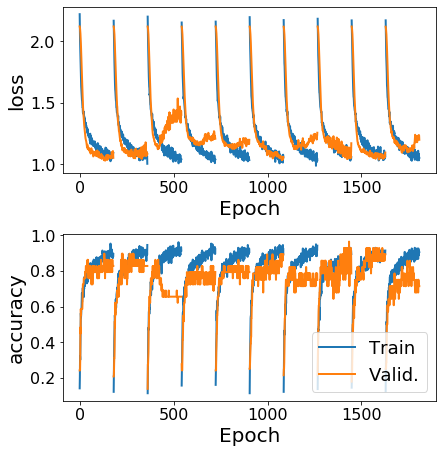

In [98]:
from indl.metrics import quickplot_history

history, accuracy = get_hists_acc(sess_infos[1]['exp_code'], verbose=2)
quickplot_history(history)

### Training and evaluation - per session

Note that using verbose=0 will suppress most of the log information. Progress indicators might only be updated once every few minutes, depending on the number of epochs and the amount of time it takes to process a session.

In [13]:
hists = []
accs = []
for sess_info in sess_infos:
    _hist, _acc = get_hists_acc(sess_info['exp_code'], verbose=0)
    hists.append(_hist)
    accs.append(_acc)
    
print(accs)

Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 70.625%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 87.01754385964912%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 78.59778597785977%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 79.42238267148015%

### Finding the Best Model (Manual Hyperparameter Optimization)

In [115]:
from datetime import datetime

input_spec = tf.data.Dataset.from_tensor_slices(X_rates).batch(16, drop_remainder=True).element_spec

dsrate = 9
rnn1s = [32, 64, 128, 256]
rnn2s = [32, 64, 128, 256]
denses = [0, 8, 16, 32, 64, 128]
meanacc = 0
best_rnn1 = 0
best_rnn2 = 0
best_dense = 0
best_acc = []
best_model = None
count=1
for rnn1 in rnn1s:
    for rnn2 in rnn2s:
        for dense in denses:
            f = open("C:/Users/alire/OneDrive/rnnLog.txt", "a")
            f.write(f"\n\nLoop # {count} of {len(rnn1s)*len(rnn2s)*len(denses)}\n")
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            f.write(str(current_time))
            print(f"Loop # {count} of 96")
            print(current_time)
            count+=1
            model_kwargs = dict(
                filt=8,
                kernLength=25,
                ds_rate=9,
                n_rnn=rnn1,
                n_rnn2=rnn2,
                dropoutRate=0.40,
                activation='relu',
                l1_reg=0.0000, l2_reg=0.001,
                norm_rate=0.25,
                latent_dim=dense
            )
            model = make_model(
                input_spec,
                **model_kwargs
            )
            hists = []
            accs = []
            for sess_info in sess_infos:
                _hist, _acc = get_hists_acc(sess_info['exp_code'], verbose=0)
                hists.append(_hist)
                accs.append(_acc)
            if np.mean(accs) > meanacc:
                meanacc = np.mean(accs)
                f.write(f"\nAverage Accuracy Improved to: {meanacc}\n")
                f.write(str(accs))
                print(f"Average Accuracy Improved to: {meanacc}")
                print(accs)
                f.write(f"\nRNN1: {rnn1}, RNN2: {rnn2}, Bottle: {dense}")
                print(f"RNN1: {rnn1}, RNN2: {rnn2}, Bottle: {dense}")
                best_rnn1 = rnn1
                best_rnn2 = rnn2
                best_dense = dense
                best_acc = accs
                best_model = model
                f.close()                    

f.close()
f.close()
f.close()

Loop # 1 of 96
15:16:14
Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 70.625%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 84.91228070175438%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 78.59778597785977%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accu

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_083_00+01 overall accuracy: 78.82352941176471%
Loop # 5 of 96
17:49:17
Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 73.125%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 86.3157894736842%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 77.85977859778598%
Processing session sra3_1_j_

	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_083_00+01 overall accuracy: 82.3529411764706%
Loop # 9 of 96
20:22:43
Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 70.0%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 85.26315789473684%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 77.12177121771218%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split

	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_083_00+01 overall accuracy: 80.0%
Loop # 13 of 96
23:08:32
Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 70.0%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 85.6140350877193%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 76.01476014760148%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Sp

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_083_00+01 overall accuracy: 80.0%
Loop # 17 of 96
02:13:42
Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 69.375%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 86.66666666666667%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 76.38376383763837%
Processing session sra3_1_j_052_00+...


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_083_00+01 overall accuracy: 81.17647058823529%
Loop # 21 of 96
05:19:09
Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 71.875%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 87.71929824561404%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 77.12177121771218%
Processing session sra3_1_

Session sra3_1_m_082_00+01 overall accuracy: 85.9375%
Processing session sra3_1_m_083_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_083_00+01 overall accuracy: 83.52941176470588%
Loop # 25 of 96
08:26:34
Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 73.125%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 88.0701754385965%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 o

	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_083_00+01 overall accuracy: 80.0%
Loop # 29 of 96
11:16:13
Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 71.25%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 87.36842105263158%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 80.44280442804428%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	

Processing session sra3_2_j_037_00+03...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 70.0%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 86.3157894736842%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 78.96678966789668%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 77.9783393501805%
Pro

	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 69.375%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 87.36842105263158%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 78.96678966789668%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 80.86642599277978%
Processing session sra3_1_m_077_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 73.125%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 85.26315789473684%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 77.12177121771218%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 78.33935018050542%
Processing session sra3_1_m_077_00+01...
	Split 1 of 10

	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 71.25%
Processing session sra3_1_j_050_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 88.0701754385965%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 77.49077490774907%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 80.14440433212997%
Processing session sra3_1_m_077_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 86.66666666666667%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 80.44280442804428%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 76.89530685920577%
Processing session sra3_1_m_077_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_077_00+01 overall accuracy: 63.28125%
Processing session sra3_1_m_081_00+01...
	Split 1 o

	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 86.66666666666667%
Processing session sra3_1_j_051_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 78.59778597785977%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 78.33935018050542%
Processing session sra3_1_m_077_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_077_00+01 overall accuracy: 67.1875%
Processing session sra3_1_m_081_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 79.70479704797047%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 77.25631768953069%
Processing session sra3_1_m_077_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_077_00+01 overall accuracy: 63.28125%
Processing session sra3_1_m_081_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_081_00+01 overall accuracy: 79.16666666666667%
Processing session sra3_1_m_082_00+01...
	Split

	Split 10 of 10
Session sra3_1_j_051_00+ overall accuracy: 77.49077490774907%
Processing session sra3_1_j_052_00+...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_052_00+ overall accuracy: 78.70036101083032%
Processing session sra3_1_m_077_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_077_00+01 overall accuracy: 60.9375%
Processing session sra3_1_m_081_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_m_081_00+01 overall accuracy: 78.125%
Processing session sra3_1_m_082_00+01...
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Sp

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001C84D891708>
Traceback (most recent call last):
  File "C:\Users\alire\Anaconda3\envs\mldl\lib\weakref.py", line 359, in remove
    self = selfref()
KeyboardInterrupt


KeyboardInterrupt: 

### Top 6 Models

All models have similiar architecture:
* Two covoloutional layers to decrease number of channels
* A dense layer to downsample timeseries
* First RNN (RNN1)
* Second RNN (RNN2)
* Dense Bottleneck (Botl)
* Dense Classifier

Model 1: RNN1 = 32(GRU), RNN2 = 32(GRU), Botl = 64

Model 2: RNN1 = 32(LSTM), RNN2 = 64(LSTM), Botl = 64

Model 3: RNN1 = 32(LSTM), RNN2 = 128(LSTM), Botl = 16

Model 4: RNN1 = 32(LSTM), RNN2 = 128(LSTM), Botl = 128

Model 5: RNN1 = 32(LSTM), RNN2 = 256(LSTM), Botl = 16

Model 6: RNN1 = 64(LSTM), RNN2 = 128(LSTM), Botl = 32

In [11]:
labels = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6']
data = np.array([[63.75,           73.125,             71.25,               70.,            71.875,             73.75],
                [88.42, 88.42105263157895,  86.3157894736842, 86.66666666666667, 87.71929824561404,  88.0701754385965],
                [80.71, 75.64575645756457, 77.49077490774907, 76.75276752767527, 77.12177121771218, 79.33579335793358],
                [74.,   77.61732851985559, 78.33935018050542, 80.50541516245487, 79.06137184115524, 79.06137184115524],
                [67.1875,         70.3125,          66.40625,          66.40625,           70.3125,          64.84375],
                [83.33,            71.875, 77.08333333333333,            78.125, 77.08333333333333,            78.125],
                [85.93,           79.6875,           85.9375,            84.375,            84.375,            84.375],
                [80.,   81.17647058823529, 81.17647058823529,  82.3529411764706, 81.17647058823529,  82.3529411764706]])
                     
sess_names = [_['exp_code'].split('_')[2] for _ in sess_infos]

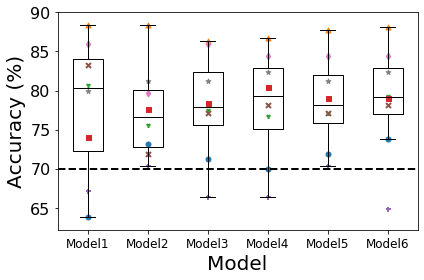

In [12]:
fig1, ax1 = plt.subplots(figsize=(6, 4))

plt.axhline(70, color='k', linestyle='--')

ax1.boxplot(data, showfliers=False, medianprops=dict(color='k'))
ax1.set_xticklabels(labels, fontsize=12)
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')

for row_ix, m in zip(range(data.shape[0]), ['o', '^', '1', 's', '+', 'x', 'd', '*']):
    plt.scatter([1, 2, 3, 4, 5, 6], data[row_ix, :], marker=m)

plt.tight_layout()
fig1.savefig('classif_acc.png')